# Taylor Imhof
# Bellevue University | DSC 680
# Project Two Notebook

## Importing Required Libraries

In [1]:
# import required libraries
import praw
from IPython import display
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import tensorflow as tf

sns.set(style='darkgrid')

## Obtaining Reddit r/politics Headlines

In [2]:
reddit = praw.Reddit(client_id='vm4lkJvkhWM00FjppcHjPA',
                     client_secret='m2-rS76QQV22MAUv2E7bB0YzRA0U4w',
                     user_agent='MrKimhof')

Version 7.5.0 of praw is outdated. Version 7.6.1 was released 6 days ago.


In [3]:
# define set for headlines
# set removes chances of getting duplicate headlines
headlines = set()

In [4]:
# for each post is the /r/politics subreddit, iterate through and extract the headlines
for post in reddit.subreddit('politics').new(limit=None):
    headlines.add(post.title)
    display.clear_output()
    print(len(headlines))

992


In [5]:
# download lexicon and stopwords from nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\taylo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taylo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Train VADER Model (Sentiment Intensity Analyzer)

In [6]:
# use vader SIA to rank each portion of the text as positive, negative, or neutral

# create new sia object
sia = SIA()
results = [] # empty to list to append calculated polarity scores

# iterate through each headline in set and append to results list
for headline in headlines:
    polarity = sia.polarity_scores(headline)
    polarity['headlines'] = headline
    results.append(polarity)

# print results to ensure scores encoded properly
pprint(results[:5], width=75)

[{'compound': -0.7269,
  'headlines': 'Karine Jean-Pierre blasted for warning it may take ‘a few '
               'days’ to count votes: ‘This insanity has to stop’',
  'neg': 0.264,
  'neu': 0.736,
  'pos': 0.0},
 {'compound': 0.0,
  'headlines': 'Lauren Boebert in Precarious Position as Final Votes May '
               'Sway Election',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.5719,
  'headlines': 'Kelly wins in Arizona, pushing Democrats closer to '
               'keeping Senate',
  'neg': 0.0,
  'neu': 0.709,
  'pos': 0.291},
 {'compound': 0.34,
  'headlines': 'Herschel Walker is a pawn in a game he’s not aware is '
               'being played',
  'neg': 0.0,
  'neu': 0.821,
  'pos': 0.179},
 {'compound': 0.5423,
  'headlines': '911 dispatchers overlooked in $1,000 bonuses from '
               'DeSantis',
  'neg': 0.103,
  'neu': 0.561,
  'pos': 0.336}]


## Create Dataframe with VADER Results

In [7]:
# create pandas dataframe from records create in previous step
df = pd.DataFrame.from_records(results)
df.head() # display first five obs to ensure data loaded properly

,neg,neu,pos,compound,headlines
0,0.264,0.736,0.000,-0.7269,Karine Jean-Pierre blasted for warning it may ...
1,0.000,1.000,0.000,0.0000,Lauren Boebert in Precarious Position as Final...
2,0.000,0.709,0.291,0.5719,"Kelly wins in Arizona, pushing Democrats close..."
3,0.000,0.821,0.179,0.3400,Herschel Walker is a pawn in a game he’s not a...
4,0.103,0.561,0.336,0.5423,"911 dispatchers overlooked in $1,000 bonuses f..."


In [8]:
df.head()

,neg,neu,pos,compound,headlines
0,0.264,0.736,0.000,-0.7269,Karine Jean-Pierre blasted for warning it may ...
1,0.000,1.000,0.000,0.0000,Lauren Boebert in Precarious Position as Final...
2,0.000,0.709,0.291,0.5719,"Kelly wins in Arizona, pushing Democrats close..."
3,0.000,0.821,0.179,0.3400,Herschel Walker is a pawn in a game he’s not a...
4,0.103,0.561,0.336,0.5423,"911 dispatchers overlooked in $1,000 bonuses f..."


In [9]:
# write data to csv for easier access later
df.to_csv('headline_data.csv')

## Encode Compound Value:
 - 0  ==> Neutral
 - 1  ==> Positive
 - -1 ==> Negative

In [10]:
# create new label column and encode:
#    0: neutral
#    1: positive (compound > +0.2)
#   -1: negative (compound < -0.2)
df['label'] = 0
df.loc[df.compound == 0, 'label'] = 0
df.loc[df.compound > 0.2, 'label'] = 1.0
df.loc[df.compound < -0.2, 'label'] = -1

# display first five obs to ensure new column added properly
df.head()

,neg,neu,pos,compound,headlines,label
0,0.264,0.736,0.000,-0.7269,Karine Jean-Pierre blasted for warning it may ...,-1
1,0.000,1.000,0.000,0.0000,Lauren Boebert in Precarious Position as Final...,0
2,0.000,0.709,0.291,0.5719,"Kelly wins in Arizona, pushing Democrats close...",1
3,0.000,0.821,0.179,0.3400,Herschel Walker is a pawn in a game he’s not a...,1
4,0.103,0.561,0.336,0.5423,"911 dispatchers overlooked in $1,000 bonuses f...",1


In [11]:
# create new df with just target label and headline feature
df2 = df[['headlines', 'label']]

## Dataset Overview and EDA

In [12]:
# view samples of positive and negative headlines
print('Below are some samples of positive headlines:\n')
pprint(list(df[df['label'] == 1].headlines)[:5], width=75)

print('\n\n' + '*' * 75 + '\n\n')

print('Below are some samples of negative headlines:\n')
pprint(list(df[df['label'] == -1].headlines)[:5], width=75)

Below are some samples of positive headlines:

['Kelly wins in Arizona, pushing Democrats closer to keeping Senate',
 'Herschel Walker is a pawn in a game he’s not aware is being played',
 '911 dispatchers overlooked in $1,000 bonuses from DeSantis',
 'US intelligence suggests Russia put off announcing Kherson retreat '
 'until after midterm elections',
 'Republicans eye Manchin as top target in 2024']


***************************************************************************


Below are some samples of negative headlines:

['Karine Jean-Pierre blasted for warning it may take ‘a few days’ to '
 'count votes: ‘This insanity has to stop’',
 'Gen Z helped to stop the ‘red wave’ in the midterms. The Republicans’ '
 'response? Try to raise the voting age',
 'Opinion | The Emperor of Chaos Has No Clothes',
 'Democrat Marie Gluesenkamp Perez scores upset victory in Washington '
 'House race',
 "GOP bomb goes off: Turning on 'toxic,' 'loser' Trump after humiliating "
 'losses']


In [13]:
# check amount of positive, negative, and neutral headlines are measured in the dataset
print(df['label'].value_counts()) # total count
print(df['label'].value_counts(normalize=True) * 100) # representation as a proportion of the data

 0    443
-1    314
 1    235
Name: label, dtype: int64
 0    44.657258
-1    31.653226
 1    23.689516
Name: label, dtype: float64


Nearly 1/2 of the headlines have been encoded as `neutral`, while approximately 32% of the headlines are `negative`. The remaining 24% are `positive`

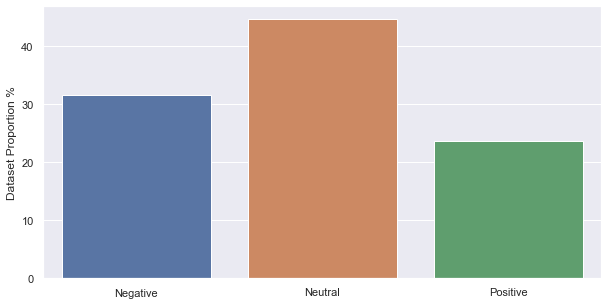

In [14]:
# view the same info as a bar chart visualization
fig, ax = plt.subplots(figsize=(10,5))

counts = df['label'].value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel('Dataset Proportion %')

plt.show()

So, something to keep in mind as the project progresses is that the dataset is quite biases towards `neutral` rating score

Another way to visualize this would be to see a distribution plot of the `compound` column, as this column is an aggregate of all three polarity scores.

C:\Users\taylo\anaconda3\envs\dsc650\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


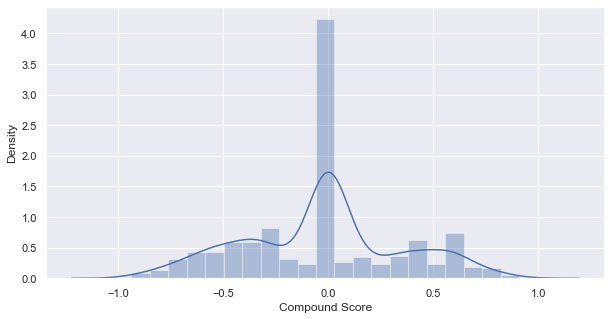

In [26]:
# plot distribution plot of compound variable
plt.figure(figsize=(10,5))
sns.distplot(df['compound'])
plt.xlabel('Compound Score')
plt.show()

As we can see, this distribution plots re-affirms that this dataset is certainly biased towards the neutral score as indicated by the massive density disparity at 0 (i.e., neutral) and the other poles (-1 and +1)

## Tokenizing The Data and Accounting For Stopwords

In [15]:
# create tokens for each record so that it can be more easily understood by a machine
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

# create new regular expression tokenizer object that removes punctuation
tokenizer = RegexpTokenizer(r'\w+')

# create new stopwords object
stop_words = stopwords.words('english')

In [16]:
# utility function that takes headlines as input, and returns clean "tokens"
def tokenize_and_remove_stopwords(headlines):
    tokens = [] # init empty list to append new tokens

    # iterate through each headline and create token and remove stopwords
    for headline in headlines:
        token = tokenizer.tokenize(headline)
        token = [t.lower() for t in token if t.lower() not in stop_words]
        tokens.extend(token)

    return tokens

In [17]:
# extract common words from positive headlines using freqdist function
positive_headlines = list(df[df['label'] == 1].headlines)

# extract tokens using utility function
positive_tokens = tokenize_and_remove_stopwords(positive_headlines)
positive_frequency = nltk.FreqDist(positive_tokens)

# display most common positive tokens
positive_frequency.most_common(15)

[('trump', 42),
 ('democrats', 41),
 ('senate', 37),
 ('wins', 31),
 ('house', 29),
 ('arizona', 27),
 ('gop', 27),
 ('win', 25),
 ('biden', 22),
 ('party', 18),
 ('supreme', 17),
 ('court', 17),
 ('election', 16),
 ('republicans', 15),
 ('desantis', 13)]

In [20]:
# extract common words from negative headlines using freqdist function
negative_headlines = list(df[df['label'] == -1].headlines)

# extrac tokens using util function
neg_tokens = tokenize_and_remove_stopwords(negative_headlines)
neg_freq = nltk.FreqDist(neg_tokens)

# display most common negative tokens
neg_freq.most_common(15)

[('trump', 85),
 ('election', 52),
 ('gop', 37),
 ('republicans', 34),
 ('arizona', 29),
 ('says', 25),
 ('republican', 23),
 ('lake', 22),
 ('house', 20),
 ('race', 20),
 ('kari', 20),
 ('senate', 19),
 ('biden', 18),
 ('defeats', 17),
 ('judge', 17)]

Interestingly, Trump shows up as the top most word for both positive and negative!

It would also appear that reddit users are not happy about a certain politician buying a new lake house?

Also, given the recent events of the midterm elections, these most common terms are not all that surprising.

### Analyzing Results of VADER Model

C:\Users\taylo\anaconda3\envs\dsc650\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\taylo\anaconda3\envs\dsc650\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Negative Word Frequency')

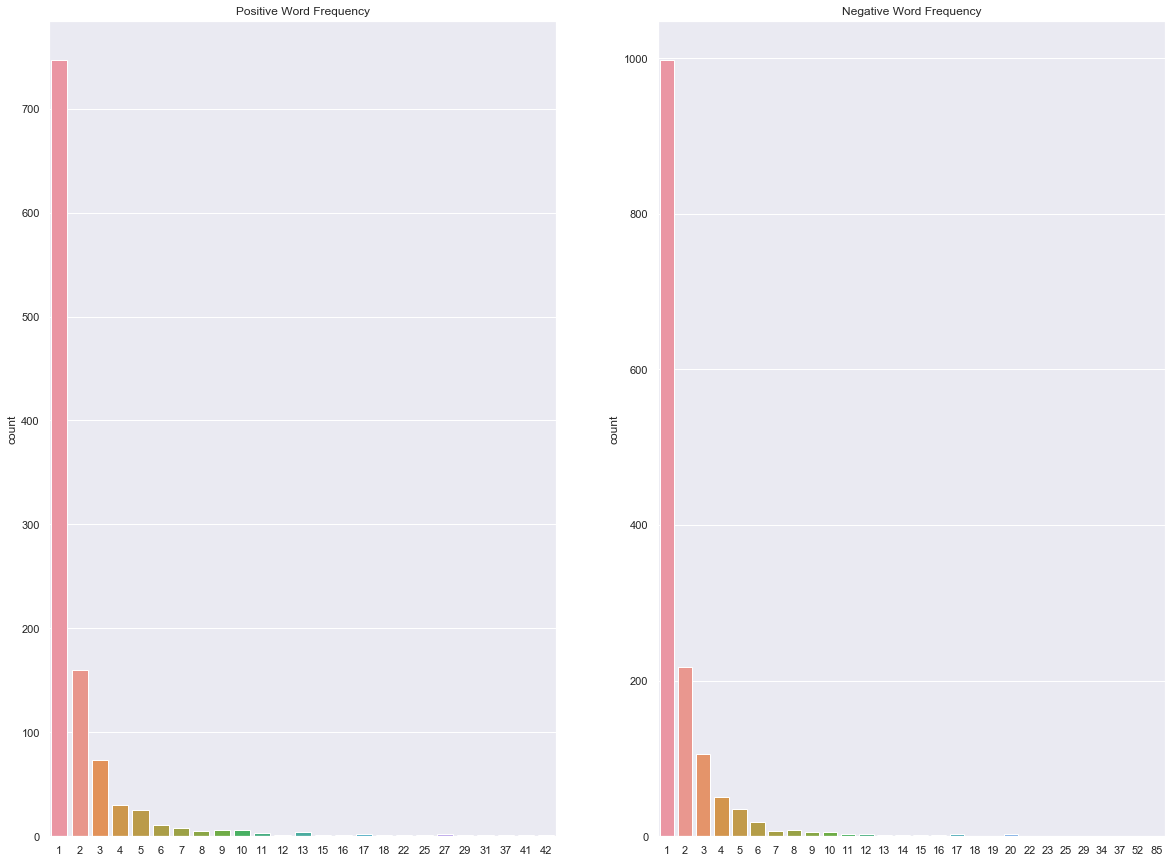

In [43]:
# view word frequency results for most common positive and negative tokens
y_val_pos = [x[1] for x in positive_frequency.most_common()]
y_val_neg = [x[1] for x in neg_freq.most_common()]

fig, axs = plt.subplots(1,2, figsize=(20,15))

sns.countplot(y_val_pos, ax=axs[0])
sns.countplot(y_val_neg, ax=axs[1])

axs[0].set_title('Positive Word Frequency')
axs[1].set_title('Negative Word Frequency')

As can be seen from the above charts, some of the tokens are used way more often than others (particularly `trump`.. surprise surprise)

## Word Clouds of Most Common Words (Positive and Negative)

In [49]:
# import wordcloud package
from wordcloud import WordCloud

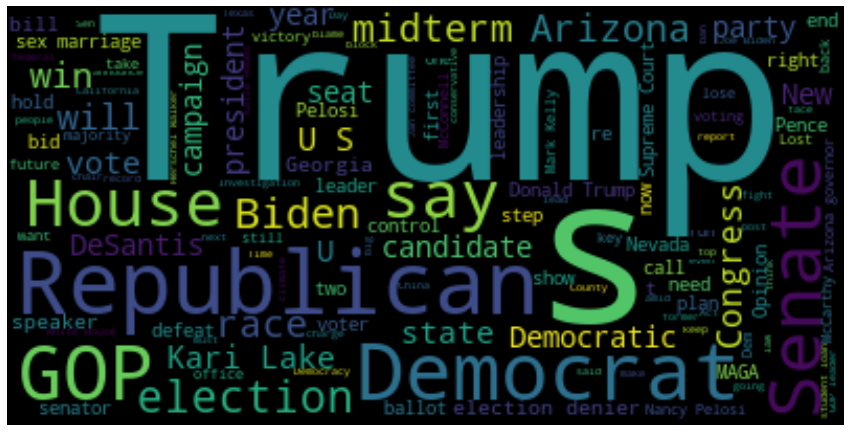

In [57]:
def plot_word_cloud(series, output_filename='worldcloud'):
    wc = WordCloud().generate(' '.join(series.astype(str)))
    wc.to_file(output_filename + '.png')
    plt.figure(figsize=(15,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
plot_word_cloud(df['headlines'], 'overall-wordcloud')